##Extracting the GTSB Dataset

In [ ]:
!gdown --id 1AudgxEPmgsP-0HrYzBKzAV0Gn2tyAJjI -O my_file.zip


/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1AudgxEPmgsP-0HrYzBKzAV0Gn2tyAJjI
From (redirected): https://drive.google.com/uc?id=1AudgxEPmgsP-0HrYzBKzAV0Gn2tyAJjI&confirm=t&uuid=3bb521e3-993d-48e1-9ae4-c1fe178c802a
To: /content/my_file.zip
100% 1.66G/1.66G [00:29<00:00, 56.9MB/s]


In [ ]:
import os
import zipfile

zip_path = "/content/my_file.zip"  # Update this path
extract_path = "/content/gtsdb"

# Unzipping the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted successfully!")



Dataset extracted successfully!


##Extracting Labels





Extract Annotations of ROIs

In [ ]:
import pandas as pd

# Path to gt.txt
gt_file = "/content/gtsdb/FullIJCNN2013/gt.txt"

# Define column names
columns = ["Filename", "Left", "Top", "Right", "Bottom", "ClassID"]

# Read the text file as a DataFrame
df = pd.read_csv(gt_file, sep=";", names=columns)

# Display first few rows
print(df.head())


    Filename  Left  Top  Right  Bottom  ClassID
0  00000.ppm   774  411    815     446       11
1  00001.ppm   983  388   1024     432       40
2  00001.ppm   386  494    442     552       38
3  00001.ppm   973  335   1031     390       13
4  00002.ppm   892  476   1006     592       39


##Image Preproccesing and Augmentation

In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Define dataset directories
dataset_path = "/content/gtsdb/FullIJCNN2013"
output_dir = "/content/yolo_dataset"

# Create YOLO dataset structure
for split in ["train", "val"]:
    os.makedirs(os.path.join(output_dir, "images", split), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "labels", split), exist_ok=True)

# Get unique image names
image_files = df["Filename"].unique()

# Split dataset (80% train, 20% val)
train_files, val_files = train_test_split(image_files, test_size=0.2, random_state=42)

# Group bounding boxes by image filename
grouped = df.groupby("Filename")

# Function to preprocess, save images & labels
def preprocess_and_save(split, filename, annotations):
    img_path = os.path.join(dataset_path, filename)

    if not os.path.exists(img_path):
        print(f"File not found: {img_path}")
        return

    # Read image
    image = cv2.imread(img_path)
    if image is None:
        print(f"Error loading image: {img_path}")
        return

    # Convert PPM to JPG
    base_filename = filename.replace(".ppm", "")

    # Define output paths
    img_output_path = os.path.join(output_dir, "images", split, base_filename + ".jpg")
    blurred_img_output_path = os.path.join(output_dir, "images", split, base_filename + "_blurred.jpg")

    # Save original image
    cv2.imwrite(img_output_path, image)

    # Apply Gaussian Blur (kernel size: 5x5, sigma: 1.5)
    blurred_image = cv2.GaussianBlur(image, (5, 5), 1.5)

    # Save blurred image
    cv2.imwrite(blurred_img_output_path, blurred_image)

    # Get image dimensions
    img_h, img_w, _ = image.shape

    # Prepare label content
    label_content = ""
    for _, row in annotations.iterrows():
        x_center = (row["Left"] + row["Right"]) / 2 / img_w
        y_center = (row["Top"] + row["Bottom"]) / 2 / img_h
        width = (row["Right"] - row["Left"]) / img_w
        height = (row["Bottom"] - row["Top"]) / img_h
        label_content += f"{row['ClassID']} {x_center} {y_center} {width} {height}\n"

    # Define label output paths
    label_output_path = os.path.join(output_dir, "labels", split, base_filename + ".txt")
    blurred_label_output_path = os.path.join(output_dir, "labels", split, base_filename + "_blurred.txt")

    # Write all bounding boxes at once
    with open(label_output_path, "w") as f:
        f.write(label_content)

    with open(blurred_label_output_path, "w") as f:
        f.write(label_content)

# Process the entire dataset
for filename, annotations in tqdm(grouped):
    split = "train" if filename in train_files else "val"
    preprocess_and_save(split, filename, annotations)

print("✅ Dataset preprocessing & Gaussian Blur augmentation complete! YOLO dataset saved in:", output_dir)


100%|██████████| 741/741 [00:14<00:00, 49.44it/s]

✅ Dataset preprocessing & Gaussian Blur augmentation complete! YOLO dataset saved in: /content/yolo_dataset


##Visualizing Train and Validation Images

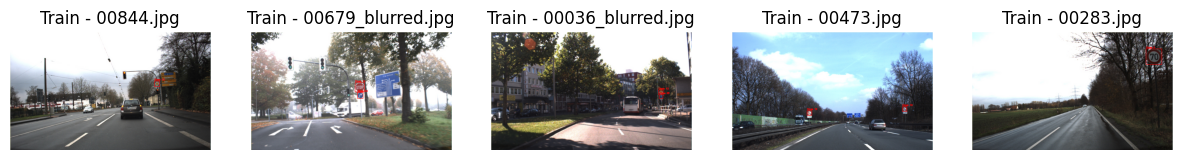

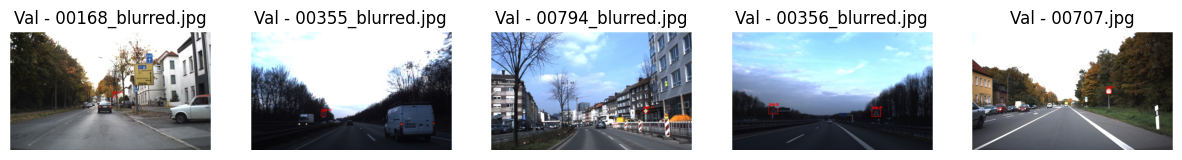

In [ ]:
import os
import cv2
import random
import matplotlib.pyplot as plt

# Define dataset directories
dataset_path = "/content/yolo_dataset"
image_dir = os.path.join(dataset_path, "images")
label_dir = os.path.join(dataset_path, "labels")

# Function to visualize images with bounding boxes horizontally
def visualize_samples_horizontally(split="train", num_samples=5):
    image_folder = os.path.join(image_dir, split)
    label_folder = os.path.join(label_dir, split)

    # Get a list of images in the split folder
    image_files = [f for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png', '.ppm'))]

    if len(image_files) == 0:
        print(f"No images found in {image_folder}")
        return

    # Randomly select images to visualize
    random_samples = random.sample(image_files, min(num_samples, len(image_files)))

    fig, axes = plt.subplots(1, len(random_samples), figsize=(15, 5))

    if len(random_samples) == 1:
        axes = [axes]  # Ensure axes is iterable when only one image is selected

    for ax, image_file in zip(axes, random_samples):
        # Read image
        img_path = os.path.join(image_folder, image_file)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for display

        # Get label file
        label_file = os.path.join(label_folder, image_file.replace(".ppm", ".txt").replace(".jpg", ".txt"))
        if not os.path.exists(label_file):
            print(f"Label not found for {image_file}")
            continue

        # Read YOLO label file
        with open(label_file, "r") as f:
            labels = f.readlines()

        # Get image dimensions
        img_h, img_w, _ = image.shape

        # Draw bounding boxes
        for label in labels:
            class_id, x_center, y_center, width, height = map(float, label.strip().split())

            # Convert YOLO format (normalized) to pixel coordinates
            x1 = int((x_center - width / 2) * img_w)
            y1 = int((y_center - height / 2) * img_h)
            x2 = int((x_center + width / 2) * img_w)
            y2 = int((y_center + height / 2) * img_h)

            # Draw rectangle and label
            cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Blue box
            cv2.putText(image, f"Class {int(class_id)}", (x1, y1 - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

        # Display the image in subplot
        ax.imshow(image)
        ax.axis("off")
        ax.set_title(f"{split.capitalize()} - {image_file}")

    plt.show()

# Visualize some training images horizontally
visualize_samples_horizontally("train", num_samples=5)

# Visualize some validation images horizontally
visualize_samples_horizontally("val", num_samples=5)


<ipython-input-7-3578ce7ae9f1>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


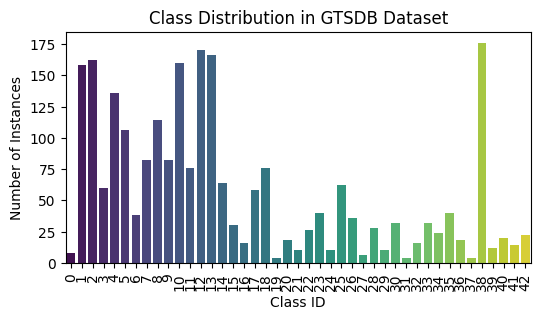

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count occurrences of each ClassID
class_counts = 2*(df["ClassID"].value_counts().sort_index())
#class occurrences are doubled since gaussian blur is added to all images and saved

# Plot the class distribution
plt.figure(figsize=(6, 3))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.xlabel('Class ID')
plt.ylabel('Number of Instances')
plt.title('Class Distribution in GTSDB Dataset')
plt.xticks(rotation=90)  # Rotate labels if necessary

# Show the plot
plt.show()


##Defining Model


In [ ]:
!pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.8/949.8 kB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
import ultralytics
ultralytics.checks()

Ultralytics 8.3.97 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 45.9/112.6 GB disk)


###Load the detection and classifier models

In [ ]:
from ultralytics import YOLO


# Load YOLOv11 detection model
detection_model = YOLO("yolo11s.pt")

print("Model loaded successfully!")


100%|██████████| 18.4M/18.4M [00:00<00:00, 268MB/s]


Model loaded successfully!


###Generating the dataset.yaml file

In [ ]:
dataset_yaml = """\
path: /content/yolo_dataset
train: images/train
val: images/val
nc: 43
names: [
    "speed limit 20 (prohibitory)",
    "speed limit 30 (prohibitory)",
    "speed limit 50 (prohibitory)",
    "speed limit 60 (prohibitory)",
    "speed limit 70 (prohibitory)",
    "speed limit 80 (prohibitory)",
    "restriction ends 80 (other)",
    "speed limit 100 (prohibitory)",
    "speed limit 120 (prohibitory)",
    "no overtaking (prohibitory)",
    "no overtaking (trucks) (prohibitory)",
    "priority at next intersection (danger)",
    "priority road (other)",
    "give way (other)",
    "stop (other)",
    "no traffic both ways (prohibitory)",
    "no trucks (prohibitory)",
    "no entry (other)",
    "danger (danger)",
    "bend left (danger)",
    "bend right (danger)",
    "bend (danger)",
    "uneven road (danger)",
    "slippery road (danger)",
    "road narrows (danger)",
    "construction (danger)",
    "traffic signal (danger)",
    "pedestrian crossing (danger)",
    "school crossing (danger)",
    "cycles crossing (danger)",
    "snow (danger)",
    "animals (danger)",
    "restriction ends (other)",
    "go right (mandatory)",
    "go left (mandatory)",
    "go straight (mandatory)",
    "go right or straight (mandatory)",
    "go left or straight (mandatory)",
    "keep right (mandatory)",
    "keep left (mandatory)",
    "roundabout (mandatory)",
    "restriction ends (overtaking) (other)",
    "restriction ends (overtaking (trucks)) (other)"
]
"""

# Save dataset.yaml
with open("/content/yolo_dataset/dataset.yaml", "w") as f:
    f.write(dataset_yaml)

print("dataset.yaml file created successfully!")


dataset.yaml file created successfully!


##Training the Detection Model

In [ ]:
import torch

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print("Using device:", device)

Using device: cuda


In [ ]:
detection_model.train(
    data="/content/yolo_dataset/dataset.yaml",  # Path to dataset config file
    epochs=50,
    imgsz=640,
    batch=32,
    device=device
)

Ultralytics 8.3.97 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/content/yolo_dataset/dataset.yaml, epochs=50, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, sh

100%|██████████| 755k/755k [00:00<00:00, 35.8MB/s]


Overriding model.yaml nc=80 with nc=43

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  1    346112  ultralytics.nn.modules.block.C3k2            [256, 256, 1, True]           
  7                  -1  1   1180672  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 164MB/s]


AMP: checks passed ✅


train: Scanning /content/yolo_dataset/labels/train... 1184 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:03<00:00, 382.82it/s]

train: New cache created: /content/yolo_dataset/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/yolo_dataset/labels/val... 298 images, 0 backgrounds, 0 corrupt: 100%|██████████| 298/298 [00:00<00:00, 329.87it/s]

val: WARNING ⚠️ /content/yolo_dataset/images/val/00340.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/yolo_dataset/images/val/00340_blurred.jpg: 1 duplicate labels removed


val: New cache created: /content/yolo_dataset/labels/val.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000213, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      8.05G      1.176      10.57      0.917         98        640: 100%|██████████| 37/37 [00:31<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.25s/it]

                   all        298        480      0.486      0.139     0.0688     0.0569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50       8.5G     0.9302      4.018     0.8386         74        640: 100%|██████████| 37/37 [00:28<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


                   all        298        480      0.377      0.297      0.219      0.179

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      8.54G     0.8868      2.836     0.8237        114        640: 100%|██████████| 37/37 [00:27<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


                   all        298        480      0.492      0.355      0.312      0.254

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      8.57G      0.829      2.103     0.8187         93        640: 100%|██████████| 37/37 [00:28<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]

                   all        298        480      0.467      0.421      0.378      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      8.61G     0.7989      1.733     0.8226        108        640: 100%|██████████| 37/37 [00:27<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]

                   all        298        480      0.478      0.427      0.397       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      8.65G      0.777      1.421      0.819         80        640: 100%|██████████| 37/37 [00:27<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]

                   all        298        480      0.571      0.464       0.48      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      8.69G     0.7446      1.266     0.8074         91        640: 100%|██████████| 37/37 [00:27<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.28it/s]

                   all        298        480      0.622      0.503      0.528      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      8.73G      0.731      1.118     0.8107         79        640: 100%|██████████| 37/37 [00:28<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]

                   all        298        480      0.697      0.455      0.507      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      8.77G     0.7032     0.9733     0.8085         79        640: 100%|██████████| 37/37 [00:27<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]

                   all        298        480      0.745      0.425       0.48        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      8.81G     0.7019     0.9318      0.808        112        640: 100%|██████████| 37/37 [00:27<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]

                   all        298        480      0.628      0.495      0.501      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      8.85G     0.6699     0.8253     0.7984         90        640: 100%|██████████| 37/37 [00:27<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.00it/s]

                   all        298        480      0.647      0.494      0.521      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      8.89G      0.676      0.754     0.8076        106        640: 100%|██████████| 37/37 [00:27<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]

                   all        298        480      0.639      0.474      0.566      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      8.93G      0.665     0.7133     0.8023        102        640: 100%|██████████| 37/37 [00:27<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.01it/s]

                   all        298        480      0.595      0.494      0.518      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      8.97G     0.6643     0.6995     0.7976        108        640: 100%|██████████| 37/37 [00:27<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]

                   all        298        480      0.721      0.487      0.524      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      9.01G     0.6279     0.6124     0.7933         84        640: 100%|██████████| 37/37 [00:27<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]

                   all        298        480      0.727      0.504      0.537      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      9.05G     0.6298     0.6159     0.7994         83        640: 100%|██████████| 37/37 [00:27<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.30it/s]

                   all        298        480      0.695      0.502      0.535      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      9.09G     0.6169     0.5888     0.7953         77        640: 100%|██████████| 37/37 [00:28<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


                   all        298        480      0.665      0.488      0.531      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      9.13G     0.6162     0.5981     0.7993         88        640: 100%|██████████| 37/37 [00:27<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]

                   all        298        480      0.553      0.509      0.515      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      9.17G     0.6083     0.5523      0.796         80        640: 100%|██████████| 37/37 [00:27<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]

                   all        298        480      0.631      0.484      0.526      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      9.21G     0.5922     0.5191     0.7994        108        640: 100%|██████████| 37/37 [00:27<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]

                   all        298        480      0.803      0.503      0.581      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      9.25G     0.5753     0.5075     0.7916         84        640: 100%|██████████| 37/37 [00:27<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]

                   all        298        480       0.67      0.497      0.558      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      9.29G     0.5832      0.492      0.792         83        640: 100%|██████████| 37/37 [00:26<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]

                   all        298        480      0.689      0.537      0.571      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      9.33G     0.5726      0.482     0.7917         81        640: 100%|██████████| 37/37 [00:27<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]

                   all        298        480      0.665      0.521      0.563      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      9.37G     0.5893     0.4749     0.7949        102        640: 100%|██████████| 37/37 [00:28<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]

                   all        298        480      0.823      0.443      0.551       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      9.41G     0.5735     0.4568     0.7899         98        640: 100%|██████████| 37/37 [00:27<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.11it/s]

                   all        298        480      0.694      0.503      0.578      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      9.45G     0.5497     0.4448     0.7902         87        640: 100%|██████████| 37/37 [00:27<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]

                   all        298        480      0.477      0.538       0.56      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      9.49G     0.5357     0.4236     0.7889        117        640: 100%|██████████| 37/37 [00:26<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]

                   all        298        480      0.622      0.525       0.54      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      9.53G     0.5451     0.4259     0.7876         83        640: 100%|██████████| 37/37 [00:27<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.25it/s]

                   all        298        480      0.702      0.535      0.592      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      9.57G     0.5234      0.419     0.7874         94        640: 100%|██████████| 37/37 [00:27<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]

                   all        298        480      0.706       0.51      0.573      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      9.61G     0.5204     0.4094     0.7875         84        640: 100%|██████████| 37/37 [00:27<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]

                   all        298        480      0.637      0.578      0.593      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      9.65G     0.5064      0.392     0.7872         88        640: 100%|██████████| 37/37 [00:26<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]

                   all        298        480       0.61      0.567      0.598       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      9.69G      0.524     0.3984     0.7838         96        640: 100%|██████████| 37/37 [00:26<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.24it/s]

                   all        298        480      0.776      0.482      0.586      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      9.73G     0.5059     0.3829     0.7876         99        640: 100%|██████████| 37/37 [00:27<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]

                   all        298        480      0.682      0.534      0.604      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      9.77G     0.5046     0.3722     0.7873         72        640: 100%|██████████| 37/37 [00:27<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]

                   all        298        480      0.671      0.545      0.583      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      9.81G     0.4725     0.3605     0.7871         78        640: 100%|██████████| 37/37 [00:27<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]

                   all        298        480      0.692      0.513      0.588      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      9.85G     0.4946      0.364     0.7888         87        640: 100%|██████████| 37/37 [00:27<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.29it/s]

                   all        298        480      0.671      0.552      0.568      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      9.89G     0.4754     0.3601     0.7851         87        640: 100%|██████████| 37/37 [00:26<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.26it/s]

                   all        298        480       0.77      0.475      0.573      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      9.93G     0.4816     0.3552     0.7865         80        640: 100%|██████████| 37/37 [00:27<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]

                   all        298        480      0.644      0.536      0.575        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      9.97G     0.4513       0.33     0.7831         83        640: 100%|██████████| 37/37 [00:27<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.26it/s]

                   all        298        480      0.699      0.564      0.579      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50        10G     0.4632     0.3366      0.787         75        640: 100%|██████████| 37/37 [00:26<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]

                   all        298        480      0.744      0.513      0.578      0.503


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50        10G     0.4614     0.3573     0.7831         50        640: 100%|██████████| 37/37 [00:30<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.31it/s]

                   all        298        480      0.735      0.503      0.565      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      10.1G     0.4401      0.332     0.7883         49        640: 100%|██████████| 37/37 [00:26<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]

                   all        298        480      0.763      0.504      0.576      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      10.1G     0.4383     0.3297     0.7793         51        640: 100%|██████████| 37/37 [00:26<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.32it/s]

                   all        298        480      0.723      0.517      0.567      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      10.2G     0.4249     0.3109     0.7792         55        640: 100%|██████████| 37/37 [00:26<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.34it/s]

                   all        298        480      0.683      0.513      0.562       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      10.2G     0.4156     0.3133     0.7774         41        640: 100%|██████████| 37/37 [00:26<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]

                   all        298        480      0.691      0.522      0.567        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      10.2G     0.4136     0.3068     0.7765         52        640: 100%|██████████| 37/37 [00:26<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]

                   all        298        480       0.76      0.502      0.579      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      10.3G     0.4041     0.3044     0.7774         48        640: 100%|██████████| 37/37 [00:26<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]

                   all        298        480      0.754      0.518      0.578      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      10.3G     0.3895     0.2915     0.7712         54        640: 100%|██████████| 37/37 [00:26<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.30it/s]

                   all        298        480      0.821      0.493      0.582      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      10.4G     0.3959     0.2952     0.7828         52        640: 100%|██████████| 37/37 [00:25<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.32it/s]

                   all        298        480      0.801       0.49      0.584      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      10.4G     0.3943     0.2932     0.7746         57        640: 100%|██████████| 37/37 [00:25<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]

                   all        298        480       0.72      0.525      0.582      0.504



50 epochs completed in 0.456 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 19.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 19.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.97 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,429,441 parameters, 0 gradients, 21.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


                   all        298        480      0.681      0.534      0.601      0.517
speed limit 20 (prohibitory)          2          2          1          0          0          0
speed limit 30 (prohibitory)         32         32      0.907      0.844      0.917      0.815
speed limit 50 (prohibitory)         20         28      0.477      0.715      0.531      0.447
speed limit 60 (prohibitory)         10         10        0.3        0.1      0.154      0.146
speed limit 70 (prohibitory)         22         34       0.59      0.676      0.689      0.617
speed limit 80 (prohibitory)         10         16      0.533      0.625      0.623       0.54
restriction ends 80 (other)          6         12          1      0.666      0.872      0.723
speed limit 100 (prohibitory)          6         10      0.702        0.8      0.852       0.77
speed limit 120 (prohibitory)         10         16      0.578          1      0.912      0.796
no overtaking (prohibitory)         24         24      

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 37, 38, 39, 41, 42])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b23403e64d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.

##Visualize The Metrics


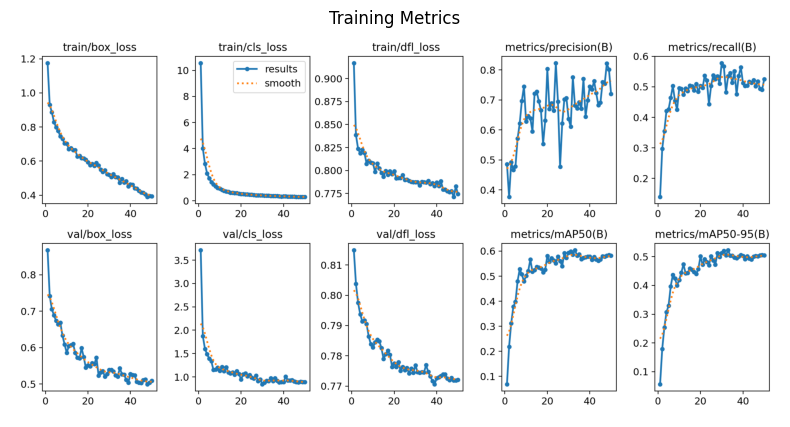

In [ ]:
import matplotlib.pyplot as plt
import cv2

# Path to the results image
results_path = "/content/runs/detect/train/results.png"

# Load and display the image
image = cv2.imread(results_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct colors

plt.figure(figsize=(10, 5))
plt.imshow(image)
plt.axis("off")  # Hide axis
plt.title("Training Metrics")
plt.show()


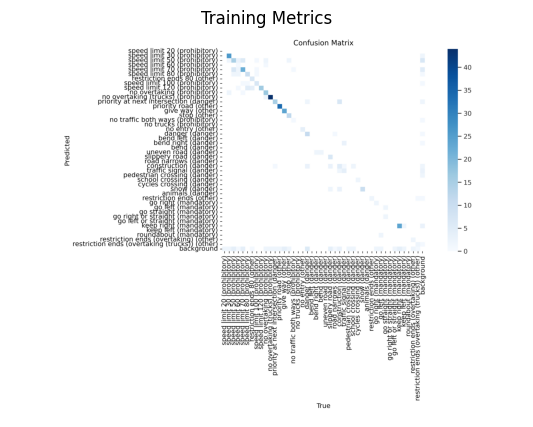

In [ ]:
import matplotlib.pyplot as plt
import cv2

# Path to the results image
results_path = "/content/runs/detect/train/confusion_matrix.png"

# Load and display the image
image = cv2.imread(results_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct colors

plt.figure(figsize=(10, 5))
plt.imshow(image)
plt.axis("off")  # Hide axis
plt.title("Training Metrics")
plt.show()


##Download the Detect model Weights to PC

In [ ]:
from google.colab import files
import shutil

# Specify the path to the best.pt file
model_path = '/content/runs/detect/train/weights/best.pt'  # Corrected model path

# Download the model weights directly to your local computer
files.download(model_path)  # Directly download the .pt file without zipping



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Save the model weights
torch.save(detection_model.state_dict(), '/content/yolo_model_weights.pth')
print("Model weights saved to /content/yolo_model_weights.pth!")


Model weights saved to /content/yolo_model_weights.pth!


In [ ]:
# Assuming `detection_model` is your YOLO model
# Save the model architecture and state_dict (weights) in separate files
torch.save(detection_model.yaml, '/content/yolo_model_config.yaml')

